# **W1D3: Remote Sensing for Climate**

# **Tutorial 4: Understanding Climatology - Precipitation**

**Week 1, Day 3, Remote Sensing**

**Content creators:** Douglas Rao

**Content reviewers:** Katrina Dobson, Younkap Nina Duplex, Danika Gupta, Maria Gonzalez, Will Gregory, Nahid Hasan, Sherry Mi, Beatriz Cosenza Muralles, 

**Content editors:** Jenna Pearson, Chi Zhang, Ohad Zivan

**Production editors:** Wesley Banfield, Jenna Pearson, Chi Zhang, Ohad Zivan

**Our 2023 Sponsors:** NASA TOPS

# **Tutorial Objectives**

In this tutorial, you will explore the concept of climatology and learn how to leverage it using satellite climate data.

Upon completing this tutorial, you'll be able to:

- Comprehend the fundamentals of climatology.
- Compute climatology utilizing long-term satellite climate data.
- Create informative maps inclusive of features such as projections, coastlines, and other advanced components.

Throughout this tutorial, we'll employ the NOAA's monthly precipitation climate data records as our primary resource for demonstrating the process of calculating long-term climatology for climate analysis. Specifically, we'll use the [Global Precipitation Climatology Project (GPCP) Monthly Precipitation Climate Data Record (CDR)](https://www.ncei.noaa.gov/products/climate-data-records/precipitation-gpcp-monthly). As part of our investigation, we'll focus on a specific location, observing its data across the entire time duration covered by the GPCP monthly dataset.

# **Setup**



In this section, we have:


1.   **Import cell:** imports all libraries you use in the tutorial.
2.   **Hidden Figure settings cell:** sets up the plotting style (copy exactly)
1.   **Hidden Plotting functions cell:** contains all functions used to create plots throughout the tutorial (so students don't waste time looking at boilerplate matplotlib but can here if they wish to). Please use only matplotlib for plotting for consistency.
2.   **Hidden Helper functions cell:** This should contain functions that students have previously used or that are very simple. Any helper functions that are being used for the first time and are important should be placed directly above the relevant text or exercise (see Section 1.1 for an example).
    



In [1]:
#google colan installs

# !pip install s3fs --quiet

# Properly install cartopy in colab to avoid session crash
# !apt-get install libproj-dev proj-data proj-bin --quiet
# !apt-get install libgeos-dev --quiet
# !pip install cython --quiet
# !pip install cartopy --quiet

# !apt-get -qq install python-cartopy python3-cartopy  --quiet
# !pip uninstall -y shapely  --quiet
# !pip install shapely --no-binary shapely  --quiet

In [1]:
#Imports

import s3fs
import xarray as xr
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import boto3
import botocore
import pooch


In [2]:
# @title Figure settings
import ipywidgets as widgets       # interactive display
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/ClimateMatchAcademy/course-content/main/cma.mplstyle")

# **Section 1: Access Monthly Precipitation Data**



In [4]:
# @title Video 1: Video 1 Name
#Tech team will add code to format and display the video

In this tutorial, our objective is to demonstrate how to calculate long-term climatology for climate analysis using monthly precipitation climate data records from NOAA. 

We'll be utilizing the [Global Precipitation Climatology Project (GPCP) Monthly Precipitation Climate Data Record (CDR)](https://www.ncei.noaa.gov/products/climate-data-records/precipitation-gpcp-monthly). This dataset furnishes us with monthly satellite-gauge and corresponding precipitation error estimates from January 1979 to the present, gridded at a 2.5°×2.5° resolution. The CDR is a compilation of precipitation data from multiple satellites and in-situ sources, combined into a final product that optimizes the advantages of each type of data, thereby offering a more accurate record.

While a higher spatial resolution (1°×1°) at daily resolution exists for varied applications, we will restrict ourselves to the coarser resolution monthly data due to computational limitations. However, you are encouraged to delve into the daily higher resolution data for your specific project needs.


## **Section 1.1: Access GPCP Monthly CDR data on AWS**

To perform analysis, we will need to access the monthly data files from AWS first. We will use the skills that we learned from last tutorial on accessing data from an AWS S3 bucket.

In [3]:
# Connect to the AWS S3 bucket for the GPCP Monthly Precipitation CDR data
fs = s3fs.S3FileSystem(anon=True)

# Get the list of all data files in the AWS S3 bucket fit the data file pattern.
file_pattern = 'noaa-cdr-precip-gpcp-monthly-pds/data/*/gpcp_v02r03_monthly_*.nc'
file_location = fs.glob(file_pattern)

In [4]:
print("Total number of GPCP Monthly precipitation data files:")
print(len(file_location))

Total number of GPCP Monthly precipitation data files:
530


We have more than 500 GPCP monthly precipitation CDR data files in the AWS S3 bucket. Each data file contains the data of each month globally starting from January 1979. Now, let's open a single data file to look at the data structure before we open all data files.

In [5]:
# First, open a client connection
client = boto3.client('s3', config=botocore.client.Config(signature_version=botocore.UNSIGNED)) # initialize aws s3 bucket client

# Read single data file to understand the file structure
ds_single = xr.open_dataset(pooch.retrieve('http://s3.amazonaws.com/'+file_location[0],known_hash=None )) # open the file
# Check how many variables are inluded in one data file
ds_single.data_vars 


Data variables:
    lat_bounds    (latitude, nv) float32 ...
    lon_bounds    (longitude, nv) float32 ...
    time_bounds   (time, nv) datetime64[ns] ...
    precip        (time, latitude, longitude) float32 ...
    precip_error  (time, latitude, longitude) float32 ...

From the information provided by `xarray`, there are a total of five data variables in this monthly data file, including `precip` for the monthly precipitation and `precip_error` for the monthly precipitation error.


In [6]:
# Check the coordinates for the data file
ds_single.coords

Coordinates:
  * latitude   (latitude) float32 -88.75 -86.25 -83.75 ... 83.75 86.25 88.75
  * longitude  (longitude) float32 1.25 3.75 6.25 8.75 ... 353.8 356.2 358.8
  * time       (time) datetime64[ns] 1979-01-01

All data is organised in three dimensions: `latitude`, `longitude`, and `time`. If we want to create a three-dimensional data array for the monthly precipitation data across the entire data period (from January 1979 until present).

In [7]:
# Open all the monthly data files and concatenate them along the time dimension.
# This process will take ~ 5 minute to complete due to the number of data files.

file_ob = [pooch.retrieve('http://s3.amazonaws.com/'+file,known_hash=None ) for file in file_location]

In [8]:
ds = xr.open_mfdataset(file_ob, combine='nested', concat_dim='time')
ds

<xarray.Dataset>
Dimensions:       (latitude: 72, longitude: 144, time: 530, nv: 2)
Coordinates:
  * latitude      (latitude) float32 -88.75 -86.25 -83.75 ... 83.75 86.25 88.75
  * longitude     (longitude) float32 1.25 3.75 6.25 8.75 ... 353.8 356.2 358.8
  * time          (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2023-02-01
Dimensions without coordinates: nv
Data variables:
    lat_bounds    (time, latitude, nv) float32 dask.array<chunksize=(1, 72, 2), meta=np.ndarray>
    lon_bounds    (time, longitude, nv) float32 dask.array<chunksize=(1, 144, 2), meta=np.ndarray>
    time_bounds   (time, nv) datetime64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>
    precip        (time, latitude, longitude) float32 dask.array<chunksize=(1, 72, 144), meta=np.ndarray>
    precip_error  (time, latitude, longitude) float32 dask.array<chunksize=(1, 72, 144), meta=np.ndarray>
Attributes: (12/45)
    Conventions:                CF-1.6, ACDD 1.3
    title:                      Global Precipitation Climatatology Project (G...
    source:                     oc.197901.sg
    references:                 Huffman et al. 1997, http://dx.doi.org/10.117...
    history:                    1) �R
`�, Dr. Jian-Jian Wang, U of Maryland,...
    Metadata_Conventions:       CF-1.6, Unidata Dataset Discovery v1.0, NOAA ...
    ...                         ...
    metadata_link:              gov.noaa.ncdc:C00979
    product_version:            v23rB1
    platform:                   NOAA POES (Polar Orbiting Environmental Satel...
    sensor:                     AVHRR>Advanced Very High Resolution Radiometer
    spatial_resolution:         2.5 degree
    comment:                    Processing computer: eagle2.umd.edu

In the above code, we used `combine='nested', concat_dim='time'` to combine all monthly precipitation data into one data array along the dimension of `time`. This command is very useful when reading in multiple data files of same structure but for different parts of the full data record.

Since we are mostly interested in the precipitation data globally at this moment, let's extract the data array of precipitation from the entire dataset.

In [9]:
# Examine the precipitation data variable
precip = ds.precip
precip

<xarray.DataArray 'precip' (time: 530, latitude: 72, longitude: 144)>
dask.array<concatenate, shape=(530, 72, 144), dtype=float32, chunksize=(1, 72, 144), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 -88.75 -86.25 -83.75 ... 83.75 86.25 88.75
  * longitude  (longitude) float32 1.25 3.75 6.25 8.75 ... 353.8 356.2 358.8
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2023-02-01
Attributes:
    long_name:      NOAA Climate Data Record (CDR) of GPCP Monthly Satellite-...
    standard_name:  precipitation amount
    units:          mm/day
    valid_range:    [  0. 100.]
    cell_methods:   area: mean time: mean

As you can see, the data array has the dimensions of `time` `longitude` `latitude`. Before delving into further analysis, let's visualize the precipitation data to gain a better understanding of its patterns and characteristics. 

## **Section 1.2: Visualize GPCP Data with Additional Map Features**

In previous tutorials, we've learned how to make simple visualization using `matplotlib` using `latitude` and `longitude` as the y-axis and x-axis.

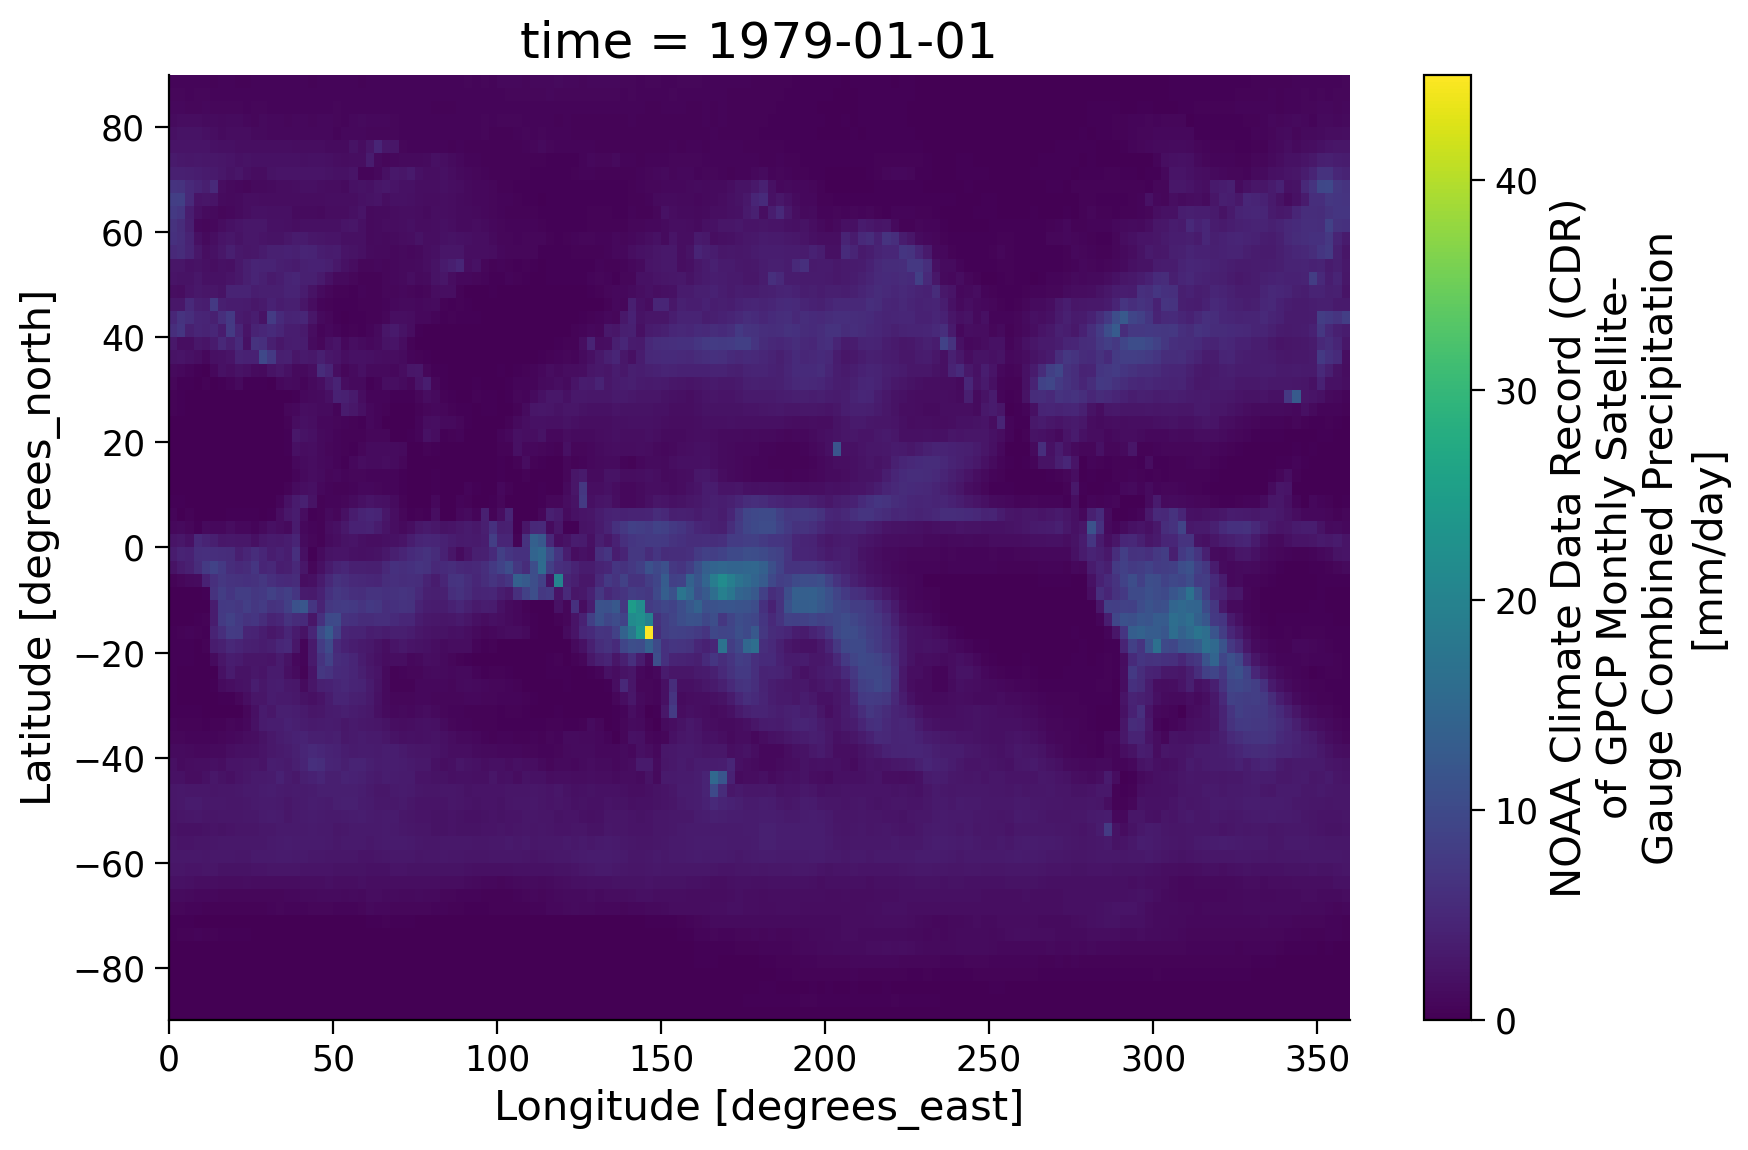

In [10]:
# Create simple map of the GPCP precipitation data using matplotlib
fig = plt.figure(figsize=(9,6))
# Use the first month of data as an example
precip.sel(time='1979-01-01').plot()

From the figure, the boundary between land and ocean, especially for North and South America, can be observed vaguely. However, this visualization is not ideal as it requires some guesswork in identifying the specific regions. To overcome this limitation and enhance the visualization, we will employ `cartopy`, a library that offers advanced mapping features. With `cartopy`, we can incorporate additional elements such as coastal lines, major grid markings, and specific map projections. This approach ensures improved clarity and facilitates better communication of scientific findings and climate applications.

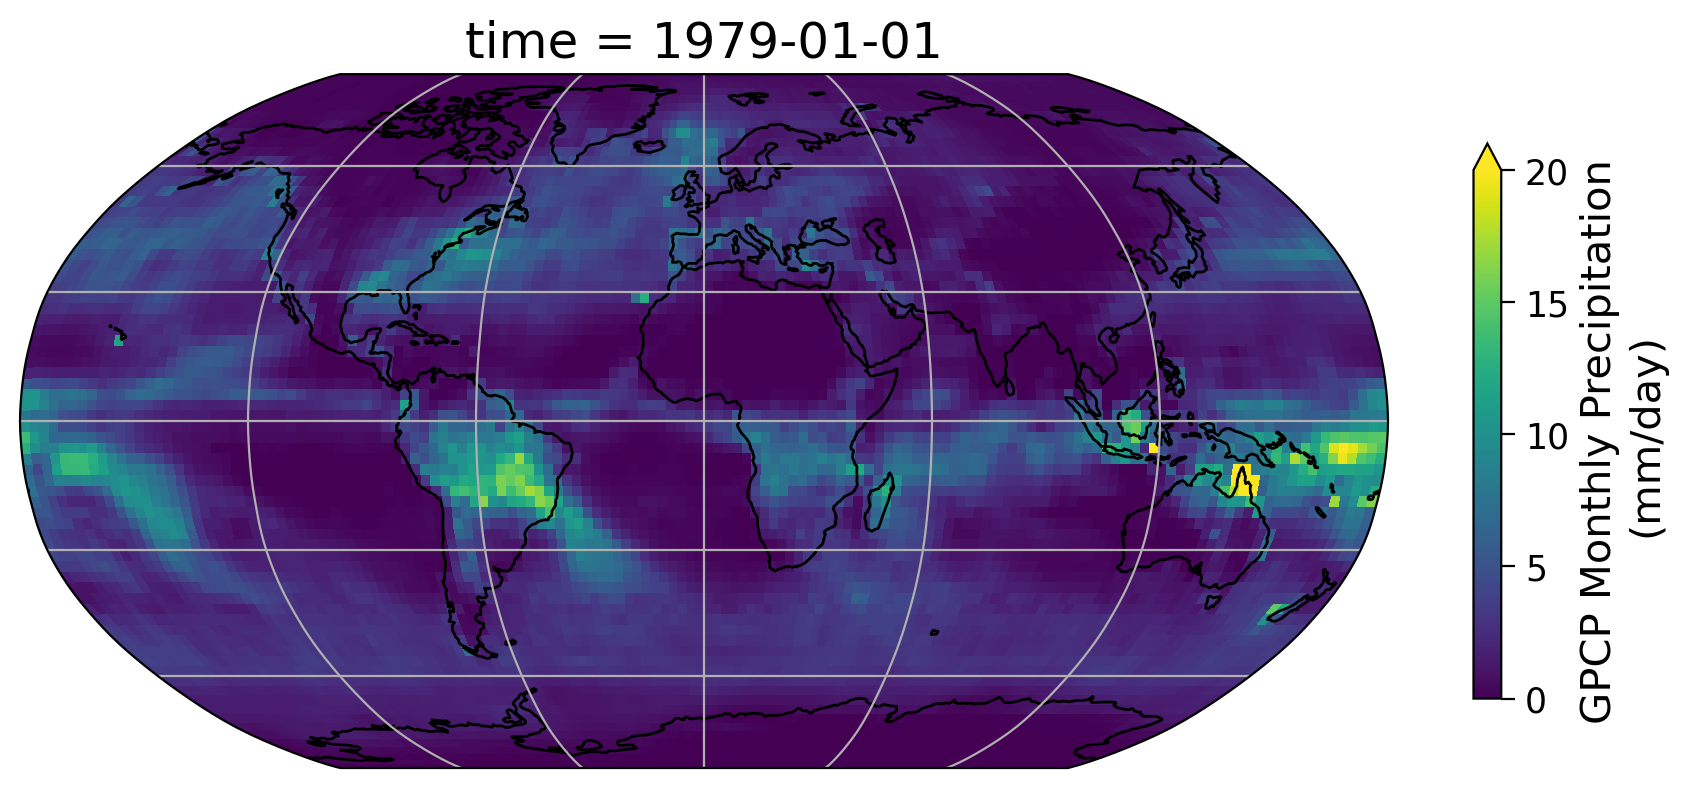

In [11]:
# Visualize the precipitation data of a selected month using cartopy
# Select data for the month of interest
data = precip.sel(time='1979-01-01', method='nearest')
# Initate plot with the specific figure size
fig = plt.figure(figsize=(9,6))
# Set base map projection
ax = plt.axes(projection=ccrs.Robinson())
# Add coastal lines to indicate land/ocean
ax.coastlines()
# Add major grid lines for latitude and longitute
ax.gridlines()
# Add the precipitation data with map projection transformation
# Also specify the maximum and minumum value show on the map to increase the
# contrast in the map.
data.plot(ax=ax, transform=ccrs.PlateCarree(),
          vmin=0, vmax=20, cbar_kwargs=dict(shrink=0.5, label='GPCP Monthly Precipitation \n(mm/day)'))

The updated map provides significant improvements, offering us a wealth of information to enhance our understanding of the GPCP monthly precipitation data. From the visualization, we can observe that regions such as the Amazon rainforest, the northern part of Australia, and other tropical areas exhibit higher levels of monthly precipitation in January 1979. These patterns align with our basic geographical knowledge, reinforcing the validity of the data and the accuracy of the representation.

### **Exercise 1.2: How big is the error?**

Remember GPCP also offers a data variable that documents the error of the estimated monthly precipitation data. This error information is valuable for understanding the level of confidence we can place in the data.

For this exercise, could you generate the precipitation error for the same month (1979-01-01) using the examples provided above?

In [12]:
################################################################################
# Exercise: create precipitation error map for the month of January 1979       #
#           using GPCP monthly data.                                           #
################################################################################

# Step 1: Select data for the month of interest using '.sel'
error = ...
# Step 2: Initate plot
fig = ...
# Step 3: Set map projection
ax = ...
# Step 4: Add coastal lines to indicate land/ocean
...
# Step 5: Add grid lines for latitude and longitute
...
# Step 6: Plot the precipitation error with a reasonable data range
...

Ellipsis

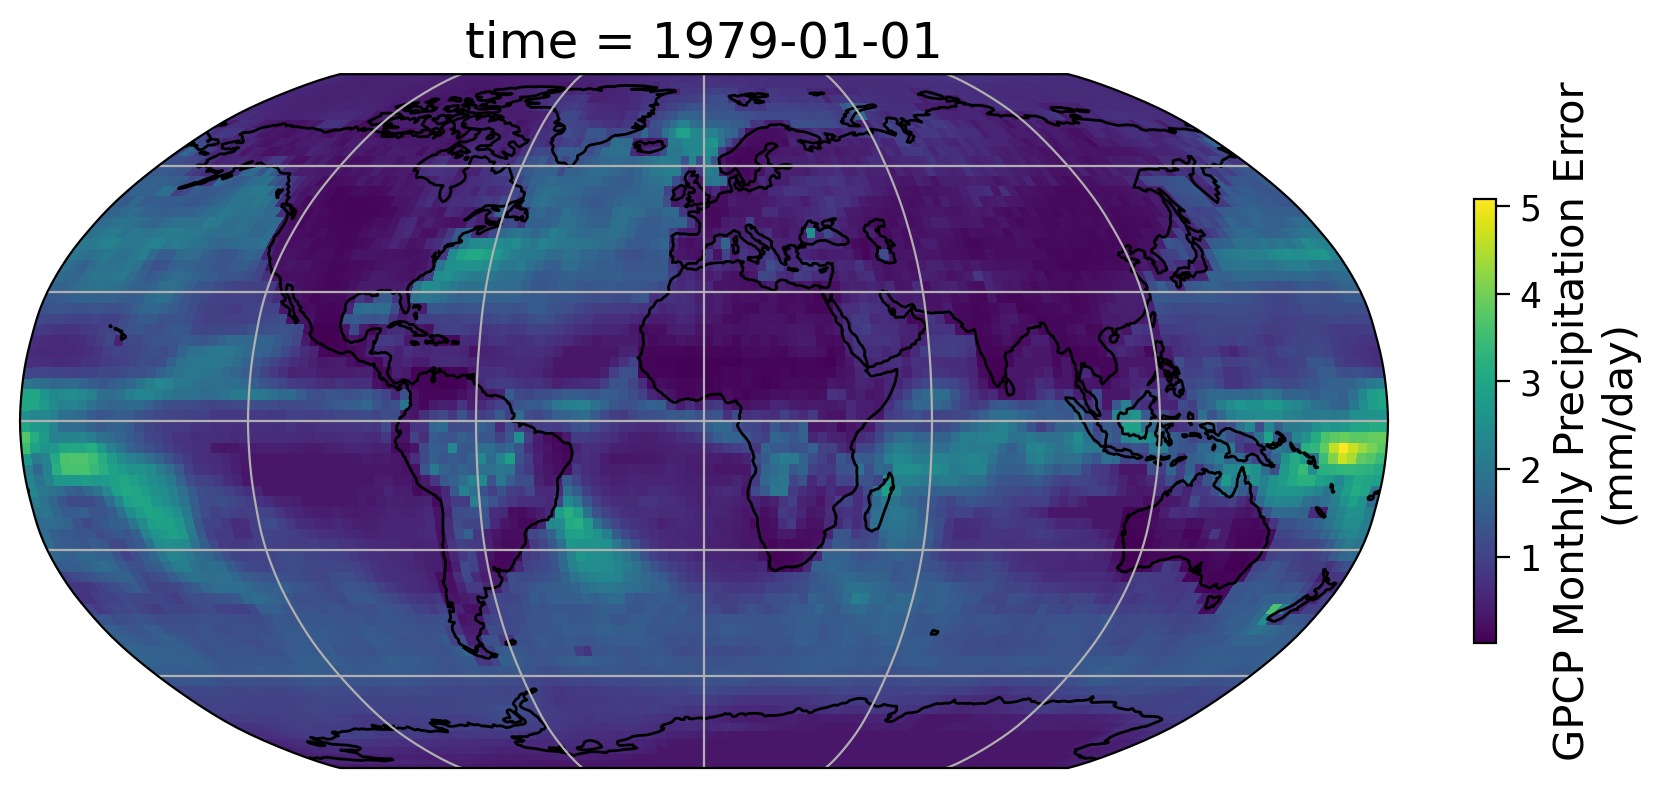

In [13]:
# to remove solution

# Select data for the month of interest
data = ds.precip_error.sel(time='1979-01-01', method='nearest')

# Initate plot
fig = plt.figure(figsize=(9,6))
# Set map projection
ax = plt.axes(projection=ccrs.Robinson())
# Add coastal lines to indicate land/ocean
ax.coastlines()
# Add grid lines for latitude and longitute
ax.gridlines()
# Add the precipitation data for
data.plot(ax=ax, transform=ccrs.PlateCarree(),
          cbar_kwargs=dict(shrink=0.4, label='GPCP Monthly Precipitation Error\n(mm/day)'))

Can you comment on the spatial pattern of the precipitation error provided by GPCP CDR data for this specific month?

In [14]:
# Please write about the error information based on the map above.
'''
Write your comments here. Where do you see the high error areas? Ocean tends to have higher errors, especially in the low latitude pacific ocean. Additionally, we can observe that South America also has higher precipitation errors.
'''

'\nWrite your comments here. Where do you see the high error areas?\n'

# **Section 2: Climatology**

We have over 40 years of monthly precipitation data. Let's examine a specific location throughout the entire time span covered by the GPCP monthly data. For this purpose, we will focus on the data point located at (0°N, 0°E).

Text(0.5, 1.0, '')

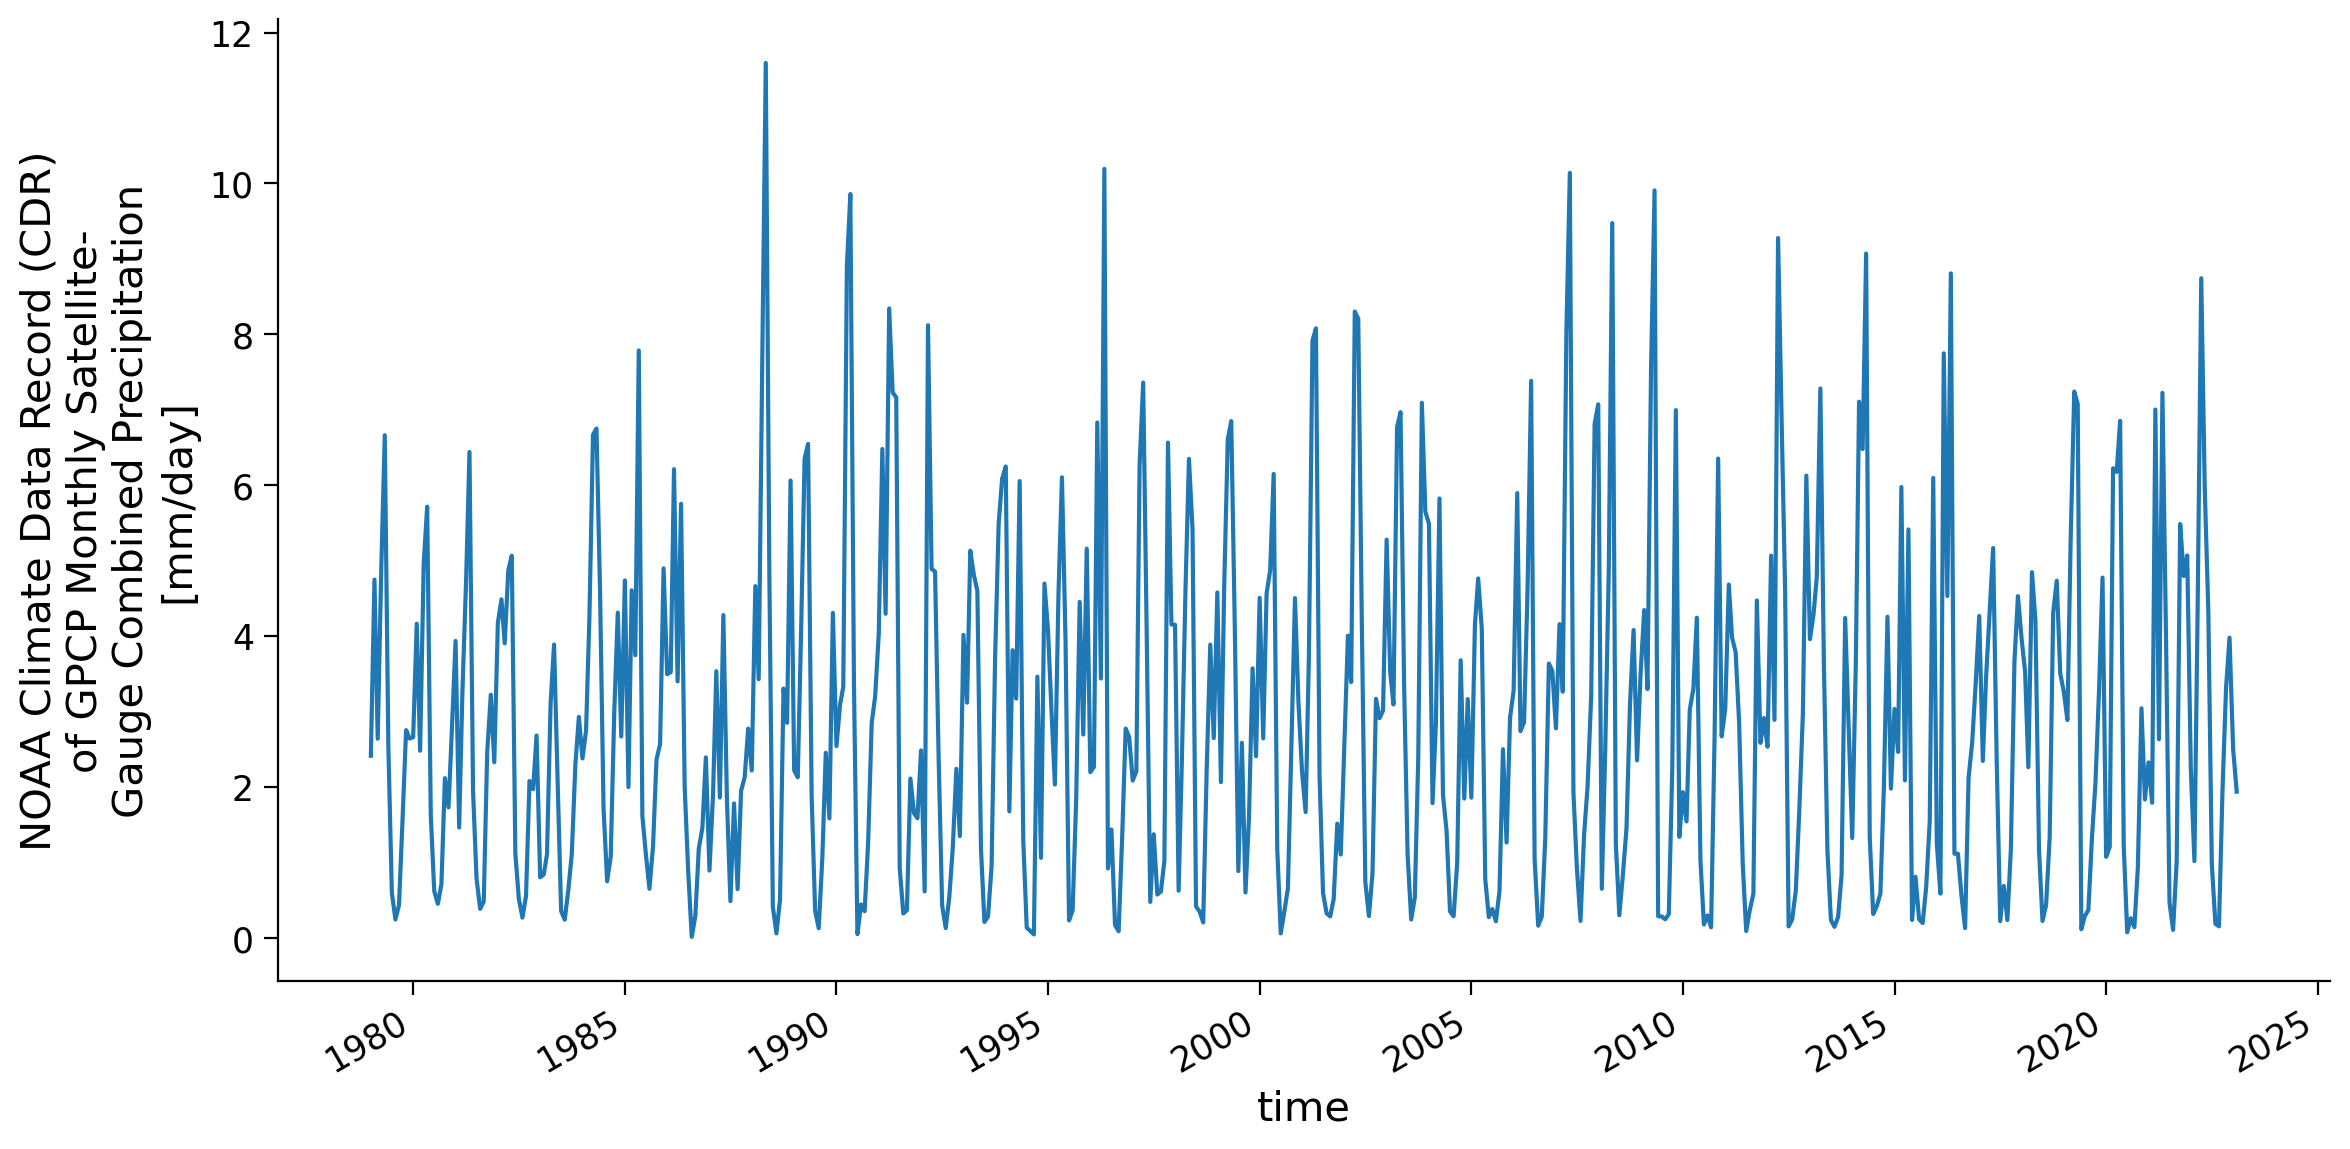

In [15]:
# select the entire time series for the grid that contains the location of (0N, 0E)
grid = ds.precip.sel(latitude=0, longitude=0, method='nearest')
# Initate plot
fig = plt.figure(figsize=(12,6))
grid.plot()
# Remove the automatically generated title
plt.title('')

From the time series plot, it appears that we have a repeating pattern with a seasonal cycle. In previous tutorials, you have learned how to calculate climatology. We can apply the same calculation to the precipitation CDR data to investigate the annual cycle of precipitation.

As a refresher, climatology typically employs a 30-year time period for calculation. In this case, let's use the reference period of 1981-2010.

In [16]:
# First, let's extract the data for the time period that we want to use to
# calulate climatology (1981-2010)
precip_30yr = ds.precip.sel(time=slice('1981-01-01', '2010-12-30'))
precip_30yr

<xarray.DataArray 'precip' (time: 360, latitude: 72, longitude: 144)>
dask.array<getitem, shape=(360, 72, 144), dtype=float32, chunksize=(1, 72, 144), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 -88.75 -86.25 -83.75 ... 83.75 86.25 88.75
  * longitude  (longitude) float32 1.25 3.75 6.25 8.75 ... 353.8 356.2 358.8
  * time       (time) datetime64[ns] 1981-01-01 1981-02-01 ... 2010-12-01
Attributes:
    long_name:      NOAA Climate Data Record (CDR) of GPCP Monthly Satellite-...
    standard_name:  precipitation amount
    units:          mm/day
    valid_range:    [  0. 100.]
    cell_methods:   area: mean time: mean

Now we have a defined time period 1981–2010 that we want to calculate climatology of. We can use `xarray` package's `groupby` functionality to easily calculate the monthly climatology.

`groupby` essentially splits the data based on a specific criterion (in this case, the month of the year) and then applies a process (in our case, calculating the mean value across 30 years for that specific month) to each group before recombining the data together.

In [17]:
# Use groupby to calculate monthly climatology (1981-2010)
precip_clim = precip_30yr.groupby('time.month').mean(dim='time')
precip_clim

<xarray.DataArray 'precip' (month: 12, latitude: 72, longitude: 144)>
dask.array<transpose, shape=(12, 72, 144), dtype=float32, chunksize=(1, 72, 144), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 -88.75 -86.25 -83.75 ... 83.75 86.25 88.75
  * longitude  (longitude) float32 1.25 3.75 6.25 8.75 ... 353.8 356.2 358.8
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Attributes:
    long_name:      NOAA Climate Data Record (CDR) of GPCP Monthly Satellite-...
    standard_name:  precipitation amount
    units:          mm/day
    valid_range:    [  0. 100.]
    cell_methods:   area: mean time: mean

With the resulting climatology data array, we can make a set of map to visualize the monthly climatology from four different seasons.

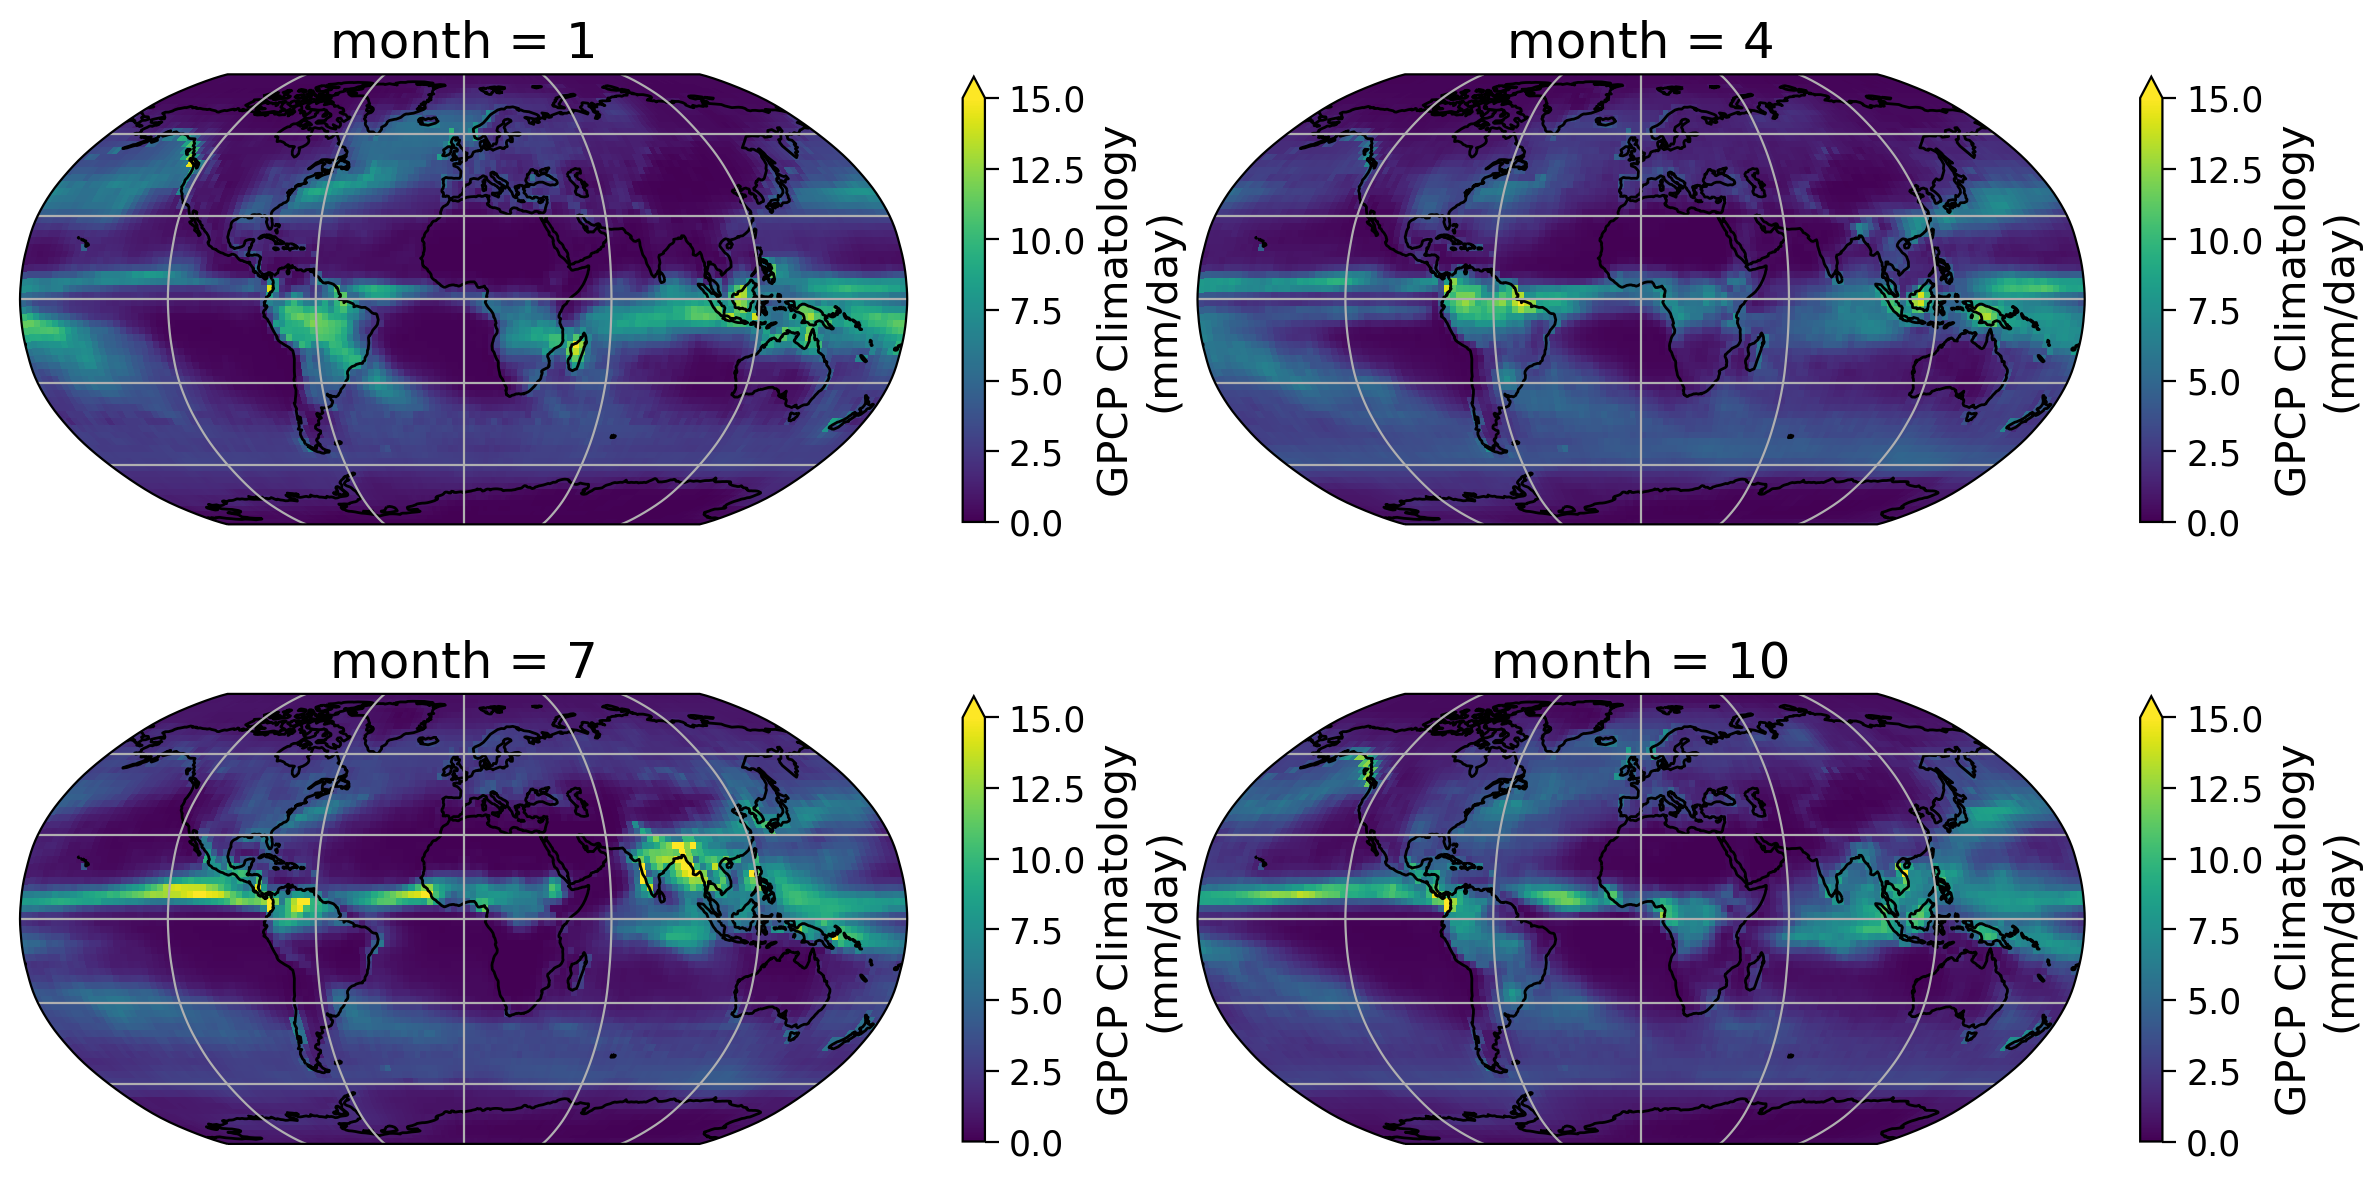

In [18]:
# Define the figure and each axis for the 2 rows and 2 columns
fig, axs = plt.subplots(nrows=2,ncols=2,
                        subplot_kw={'projection': ccrs.Robinson()},
                        figsize=(12,8))

# axs is a 2 dimensional array of `GeoAxes`.  We will flatten it into a 1-D array
axs=axs.flatten()

#Loop over selected months (Jan, Apr, Jul, Oct)
for i,month in enumerate([1,4,7,10]):

        # Draw the coastines and major gridline for each subplot
        axs[i].coastlines()
        axs[i].gridlines()

        # Draw the precipitation data
        precip_clim.sel(month=month).plot(ax=axs[i], transform=ccrs.PlateCarree(),
                        vmin = 0, vmax = 15, # use the same range of max and min value
                        cbar_kwargs=dict(shrink=0.5, label='GPCP Climatology\n(mm/day)'))

In the seasonal collection of the climatology map, we can observe a clear pattern of precipitation across the globe. The tropics exhibit a higher amount of precipitation compared to other regions. Additionally, the map illustrates the seasonal patterns of precipitation changes across different regions of the globe, including areas influenced by monsoons.

Now let's examine the climatology of the location we previously analyzed throughout the entire time series, specifically at (0°N, 0°E).

Text(0.5, 1.0, '')

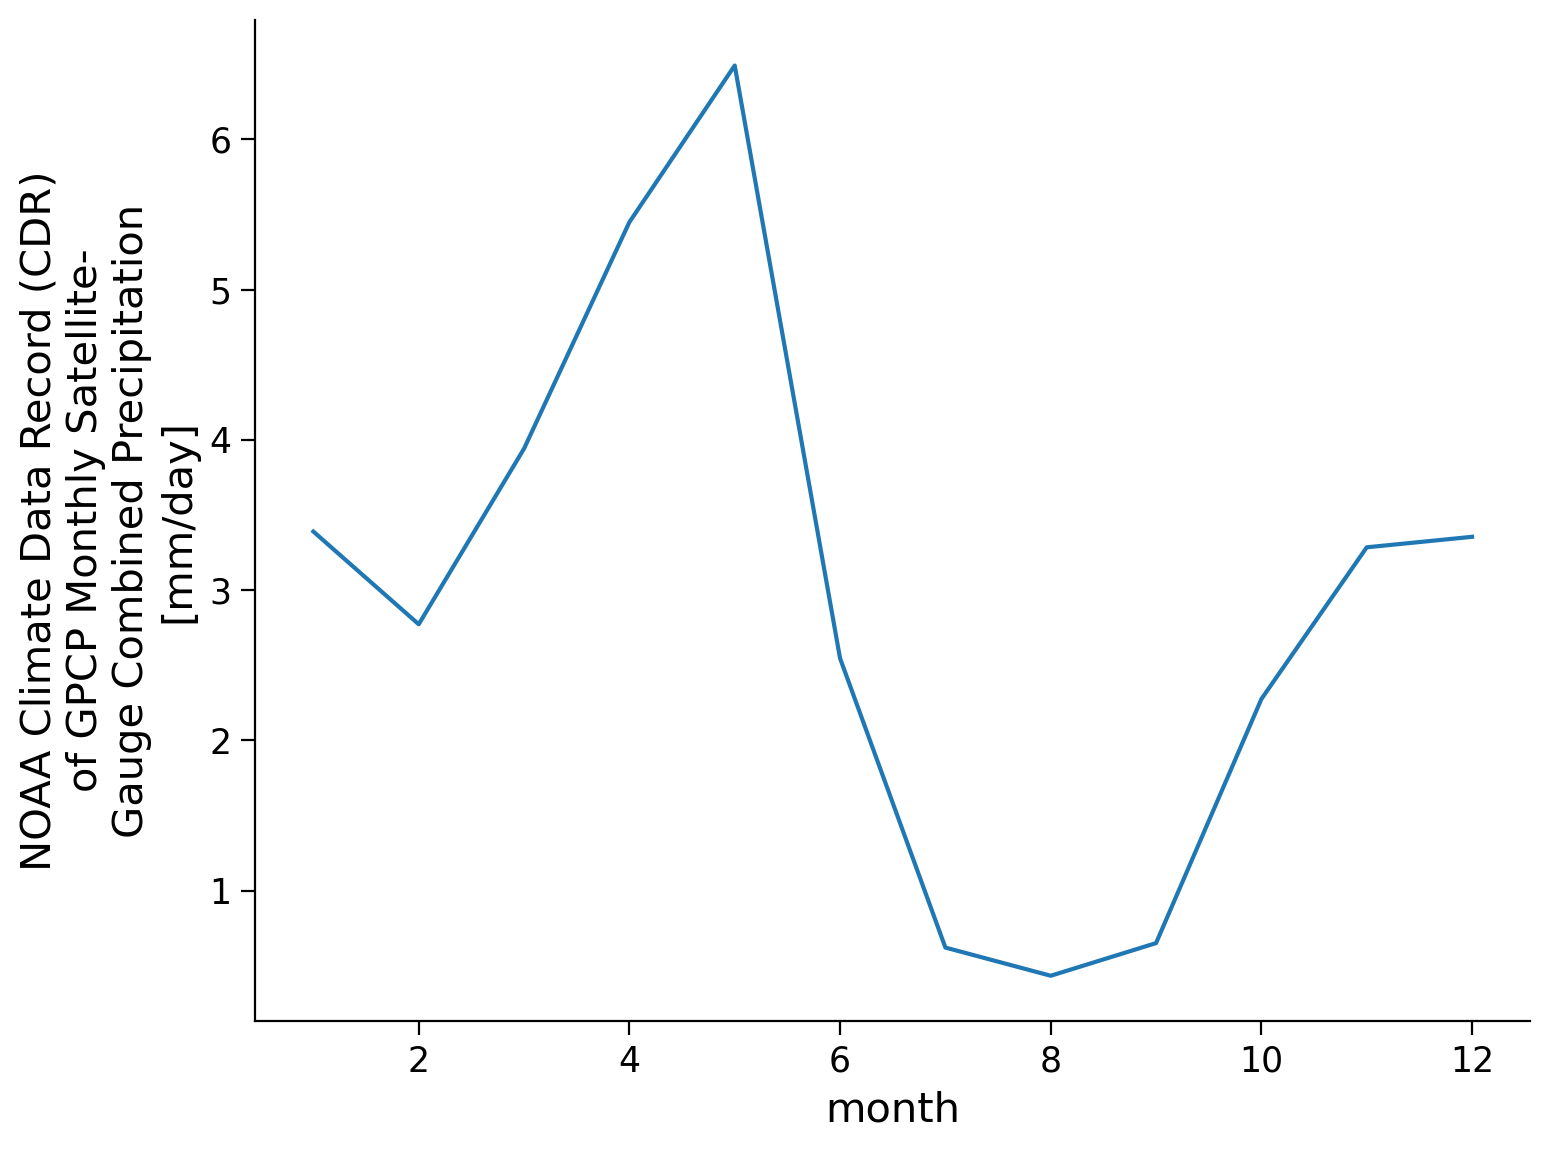

In [19]:
precip_clim.sel(latitude=0, longitude=0, method='nearest').plot()
# Remove the automatically generated title
plt.title('')


The monthly climatology time series for the point of interest demonstrates a noticeable seasonal pattern, with dry and rainy months observed in the region. Precipitation is typically more abundant between December and May, while August experiences the driest conditions throughout the year.

Climatology provides valuable insights into the typical weather patterns. By comparing the weather conditions of a specific day or month to the climatology, we can determine the extent to which they deviate from the norm. This concept of comparing against the climatology, or the norm, will be the focus of our next tutorial - anomaly!

### **Coding Exercise 2.1: Calculate Climatology Change**

As the climate change, the climatology may also change. In fact, climate researchers recalculate climatology every 10 years. This allows climate scientists to monitor how the norms of our climate system change.

In this exercise, can you calculate the climatology for a different time period (1991-2020) and compare it to the climatology that we just generated in this tutorail?

### Ohad suggetion: while the difference in years is interesting, the students don't really compare much. maybe it's more interesting to provide them a list of coordinates and have them plot the different climatology in different places on earth? all in one graph. that will show them the spatial variablity. 

In [20]:
################################################################################
# Exercise: Calculate precipitation climatology for 1991-2020 and comparing    #
#           the climatology with the 1981-2010.                                #
################################################################################

# Step 1: Extract 30 year data for 1991-2020

# Step 2: Calculate climatology for 1991-2020

# Step 3: Comparing the climatology for four different seasons by generating the
#         difference maps for January, April, July, and October



'''

Please briefly describe the difference between two climatologies using GPCP
monthly data for two different

'''

'\n\nPlease briefly describe the difference between two climatologies using GPCP\nmonthly data for two different\n\n'

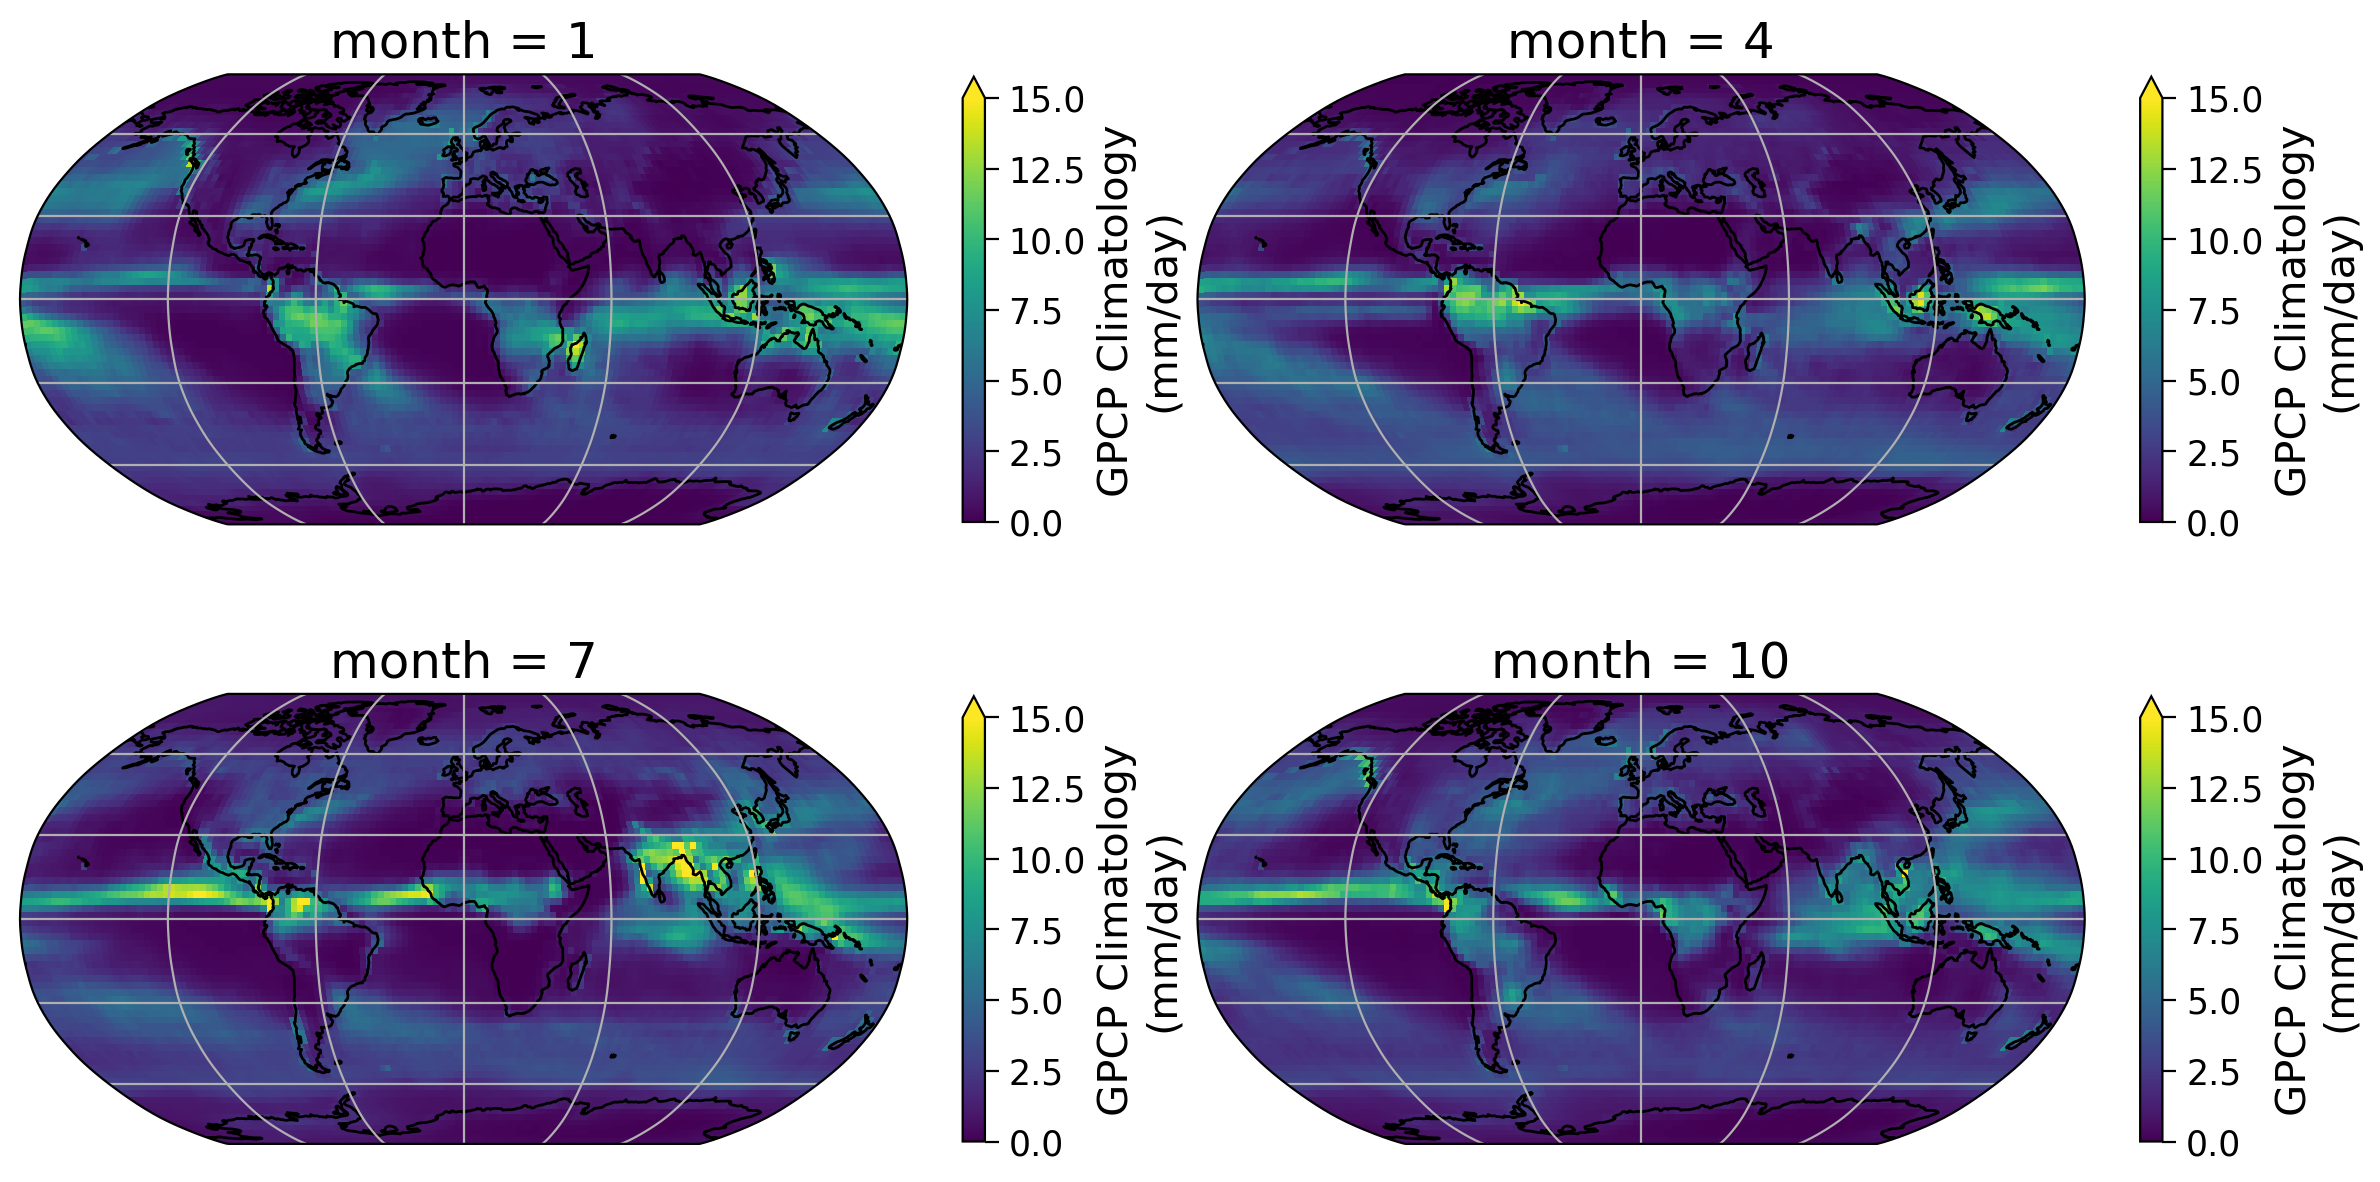

In [21]:
# to remove solution

################################################################################
# Exercise: Calculate precipitation climatology for 1991-2020 and comparing    #
#           the climatology with the 1981-2010.                                #
################################################################################

# Step 1: Extract 30 year data for 1991-2020
precip_30yr_exercise = ds.precip.sel(time=slice('1991-01-01', '2020-12-30'))

# Step 2: Calculate climatology for 1991-2020
precip_clim_exercise = precip_30yr_exercise.groupby('time.month').mean(dim='time')

# Step 3: Comparing the climatology for four different seasons by generating the
#         difference maps for January, April, July, and October

# Define the figure and each axis for the 2 rows and 2 columns
fig, axs = plt.subplots(nrows=2,ncols=2,
                        subplot_kw={'projection': ccrs.Robinson()},
                        figsize=(12,8))

# axs is a 2 dimensional array of `GeoAxes`.  We will flatten it into a 1-D array
axs=axs.flatten()

#Loop over selected months (Jan, Apr, Jul, Oct)
for i,month in enumerate([1,4,7,10]):

        # Draw the coastines and major gridline for each subplot
        axs[i].coastlines()
        axs[i].gridlines()

        # Draw the precipitation data
        precip_clim_exercise.sel(month=month).plot(ax=axs[i], transform=ccrs.PlateCarree(),
                        vmin = 0, vmax = 15, # use the same range of max and min value
                        cbar_kwargs=dict(shrink=0.5, label='GPCP Climatology\n(mm/day)'))


# **Summary**

In this tutorial, we learned the concept of climatology and its significance in understanding the average state of a system over an extended period. Key takeaways from the tutorial include:

- Climatology typically pertains to the long-term average of various system attributes, such as temperature and precipitation, often spanning a duration of 30 years.
- Satellite climate data records offer valuable insights for calculating climatology on a global scale.
- The skills acquired in this tutorial will serve as a foundation for the subsequent tutorial on analyzing anomalies.